In [1]:
# current ADAM resnet18 with 200 epochs is 76% accuracy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from numpy import asarray
import PIL.Image as Image
import torch.nn as nn
import tqdm
import gc

device = "cuda"

torch.cuda.empty_cache()
gc.collect()
        
import torchvision.transforms as transforms
transform = transforms.ToTensor()

In [2]:
patch_size = 16

# get dataset stuffs
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.utils import load_state_dict_from_url

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR100(root="based", train=False, download=True, transform=transform)

val_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


dataset = torchvision.datasets.CIFAR100(root="based", train=True, download=True, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

0it [00:00, ?it/s]

Extracting based/cifar-100-python.tar.gz to based
Files already downloaded and verified


In [3]:
!pip install vit-pytorch

In [4]:
def testb():
    acc = 0
    total = 0
    for n_, (x, y) in enumerate(val_dataloader):
        x = x.to(device)
        bs = x.shape[0]
        x = x.reshape(bs, 3, 32, 32)
        
        y_hat = v(x) # add encodings?
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [5]:

import torch
from vit_pytorch import ViT

# get ViT-B/16 model
"""
# ViT-L/8
v = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 1024,
    depth = 24,
    heads = 16,
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)
"""
#
v = ViT(
    image_size = 32,
    patch_size = patch_size,
    num_classes = 100,
    dim = 768,
    depth = 12,
    heads = 12,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
)
v.eval()

# initialize stuffs
losslist_n = []
v = v.to(device)
voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
import random

acc = 0
total = 0
# do loop for baseline
for epoch in range(50):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0
    # loop over data
    n = 0
    for (x, y) in t:
        n +=1
        bs = x.shape[0]
        
        # change device to gpu
        x = x.to(device)
        y = y.to(device)
        
        # forward pass
        x = x.reshape(bs, 3, 32, 32)
        f_y_hat = v(x)
        
        # backward pass
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss
        
        # optimize
        voptimizer.step() 
        voptimizer.zero_grad()
        
        # keep track of this epoch's loss
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
        
    # test epoch's accuracy and append it to the list
    l = testb()
    print(l)
    losslist_n.append(l)
    
# 5 = 2 normal
# new 1.8 = 5

4.020136024746193: 100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


0.1456


3.539839846228585: 100%|██████████| 196/196 [00:46<00:00,  4.25it/s]


0.1932


3.2979057815474304: 100%|██████████| 196/196 [00:46<00:00,  4.21it/s]


0.2214


3.1405292646533947: 100%|██████████| 196/196 [00:46<00:00,  4.22it/s]


0.2445


3.0091921423897525: 100%|██████████| 196/196 [00:45<00:00,  4.26it/s]


0.2564


2.8993418737111356: 100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


0.2692


2.7785275841727475: 100%|██████████| 196/196 [00:46<00:00,  4.24it/s]


0.2923


2.6765647926911487: 100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


0.3011


2.5711572327589627: 100%|██████████| 196/196 [00:46<00:00,  4.24it/s]


0.3114


2.473776415519908: 100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


0.3153


2.381706121609296: 100%|██████████| 196/196 [00:45<00:00,  4.26it/s]


0.3288


2.268806108968512: 100%|██████████| 196/196 [00:46<00:00,  4.25it/s]


0.3402


2.161486010866117: 100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


0.3451


2.041198265734058: 100%|██████████| 196/196 [00:45<00:00,  4.28it/s]


0.3511


1.9115924351106441: 100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


0.348


1.7626104209628808: 100%|██████████| 196/196 [00:46<00:00,  4.24it/s]


0.3512


1.626542299532043: 100%|██████████| 196/196 [00:47<00:00,  4.11it/s]


0.3593


1.4745808712722082: 100%|██████████| 196/196 [00:46<00:00,  4.23it/s]


0.358


1.3123658465855013: 100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


0.3648


1.1340068681591053: 100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


0.3555


0.9788448120736833: 100%|██████████| 196/196 [00:47<00:00,  4.14it/s]


0.3587


0.808931379753926: 100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


0.3619


0.6532562565682504: 100%|██████████| 196/196 [00:47<00:00,  4.11it/s]


0.3587


0.5466478996470495: 100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


0.3589


0.44441254126844065: 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]


0.3598


0.36955648509378963: 100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


0.3539


0.31949226263210856: 100%|██████████| 196/196 [00:47<00:00,  4.09it/s]


0.3576


0.2776756092981639: 100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


0.3566


0.23236114966687818: 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]


0.358


0.2103341388218294: 100%|██████████| 196/196 [00:47<00:00,  4.12it/s]


0.3584


0.2119835403364927: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3546


0.1953564948842005: 100%|██████████| 196/196 [00:47<00:00,  4.12it/s]


0.356


0.17107300346877974: 100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


0.3579


0.16347827039999405: 100%|██████████| 196/196 [00:47<00:00,  4.14it/s]


0.3588


0.1567384942534006: 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]


0.3553


0.1526617737590964: 100%|██████████| 196/196 [00:47<00:00,  4.11it/s]


0.3535


0.14016841752880116: 100%|██████████| 196/196 [00:47<00:00,  4.12it/s]


0.351


0.15128673998837544: 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


0.3541


0.12541130956659463: 100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


0.3575


0.12889124294222915: 100%|██████████| 196/196 [00:47<00:00,  4.09it/s]


0.3482


0.12526444372186807: 100%|██████████| 196/196 [00:46<00:00,  4.17it/s]


0.3565


0.11883459720514752: 100%|██████████| 196/196 [00:47<00:00,  4.16it/s]


0.3569


0.12250833462942676: 100%|██████████| 196/196 [00:47<00:00,  4.12it/s]


0.3503


0.11976044553185478: 100%|██████████| 196/196 [00:45<00:00,  4.32it/s]


0.3501


0.11703910440357808: 100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


0.3538


0.10856321499432404: 100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


0.3514


0.10321407027656052: 100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


0.3516


0.10635580266187639: 100%|██████████| 196/196 [00:45<00:00,  4.31it/s]


0.3515


0.09383568545888524: 100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


0.3616


0.1014841437944906: 100%|██████████| 196/196 [00:46<00:00,  4.17it/s]


0.3562


In [6]:
# load in ViT-b/16 results from the above code ran in previous version, I seperated these two in case the session was terminated and the data would be lost
#losslist_n = [0.3157, 0.3891, 0.439, 0.4689, 0.477, 0.4756, 0.5138, 0.5237, 0.5193, 0.5305, 0.5254, 0.5387, 0.538, 0.5333, 0.5338, 0.537, 0.5315, 0.5291, 0.5326, 0.5311, 0.5343, 0.5281, 0.5314, 0.5348, 0.5386, 0.5441, 0.5356, 0.5313, 0.5389, 0.5413, 0.5356, 0.5364, 0.5333, 0.5355, 0.5315, 0.5379, 0.532, 0.535, 0.5357, 0.5372, 0.5377, 0.5473, 0.5449, 0.5476, 0.537, 0.54, 0.5382, 0.5447, 0.5443, 0.5383, 0.5358, 0.5437, 0.5411, 0.5445, 0.5457, 0.5427, 0.5417, 0.5376, 0.5367, 0.5335, 0.5391, 0.5463, 0.5426, 0.5446, 0.5442, 0.5437, 0.5425, 0.5407, 0.5454, 0.5453, 0.5496, 0.5428, 0.544, 0.5299, 0.5423, 0.5399, 0.5405, 0.5388, 0.5386, 0.5387, 0.5513, 0.545, 0.5419, 0.537, 0.5384, 0.5405, 0.5462, 0.5379, 0.5495, 0.55, 0.5417, 0.5526, 0.5459, 0.5427, 0.5366, 0.5468, 0.5494, 0.5487, 0.5459, 0.5411, 0.5495, 0.5474, 0.5455, 0.5498, 0.5476, 0.5476, 0.5509, 0.5454, 0.5459, 0.539, 0.545, 0.5509, 0.5467, 0.5453, 0.5409, 0.5493, 0.5422, 0.5379, 0.5439, 0.5438, 0.5488, 0.5497, 0.545, 0.5481, 0.5501, 0.5567, 0.5476, 0.5431, 0.5437, 0.5458, 0.5469, 0.5469, 0.5483, 0.5442, 0.5466, 0.5471, 0.5525, 0.546, 0.5458, 0.5472, 0.5459, 0.5471, 0.5432, 0.5493, 0.5521, 0.5455, 0.5441, 0.5422, 0.5487, 0.5507, 0.5461, 0.5522, 0.5425, 0.5502, 0.5555, 0.5563, 0.5524, 0.5537, 0.5462, 0.5571, 0.5475, 0.5464, 0.548, 0.5335, 0.5488, 0.5503, 0.5507, 0.5481, 0.5403, 0.5444, 0.5473, 0.5435, 0.5491, 0.5421, 0.5532, 0.5531, 0.5546, 0.5551, 0.5534, 0.5484, 0.5433, 0.5558, 0.5452, 0.5509, 0.5482, 0.5452, 0.5556, 0.5527, 0.5511, 0.5469, 0.5474, 0.549, 0.547, 0.5456, 0.5508, 0.5471, 0.5571, 0.5499, 0.554, 0.5525]
print(losslist_n)

torch.save(v.state_dict(), "v")
#torch.save(Head.state_dict(), "H")

[0.1456, 0.1932, 0.2214, 0.2445, 0.2564, 0.2692, 0.2923, 0.3011, 0.3114, 0.3153, 0.3288, 0.3402, 0.3451, 0.3511, 0.348, 0.3512, 0.3593, 0.358, 0.3648, 0.3555, 0.3587, 0.3619, 0.3587, 0.3589, 0.3598, 0.3539, 0.3576, 0.3566, 0.358, 0.3584, 0.3546, 0.356, 0.3579, 0.3588, 0.3553, 0.3535, 0.351, 0.3541, 0.3575, 0.3482, 0.3565, 0.3569, 0.3503, 0.3501, 0.3538, 0.3514, 0.3516, 0.3515, 0.3616, 0.3562]


In [7]:
def test(f):
    acc = 0
    total = 0
    # loop over test set
    for n_, (x, y) in enumerate(val_dataloader):
        bs = x.shape[0]
        x = x.to(device)
        
        # f is how many times ViT loops over data
        for i in range(f):
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            
        # apply Head
        y_hat = Head(x)
        
        # loop over predicted and see if equal to the ground truth
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [8]:
# blank module to replace nn.Softmaxes with
class make_linear(torch.nn.Module):
    def __init__(self):
        super(make_linear, self).__init__()

    def forward(self, x):
        return x

In [9]:
def replace_layers(model, old, new):
    # stolen from stack overflow, replaces all non linearities so that transformers are linear
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

In [10]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 32,
    patch_size = 16,
    num_classes = 10,
    dim = 768,
    depth = 8,
    heads = 4,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)
v.eval()
v = torch.nn.Sequential(*(list(v.children())[:-1])) # get rid of MLP dim
# MLP dim consists of Layernorm and then activationless FC
v = torch.nn.Sequential(*(list(v.children()) + [nn.BatchNorm1d(4)])) #
#replace_layers(v, nn.Softmax, make_linear())

losslist_r = []

#Head = torch.nn.Sequential(*(list([ViT(image_size=32, patch_size=32, num_classes=10, dim=768, depth=1, heads=4, mlp_dim=3072)]))) # might want to increase head size bc the ViT is just interpresting patterns this actually makes decision
Head = torch.nn.Sequential(*(list([nn.Flatten(), nn.LayerNorm(3072), nn.Linear(3072, 100)])))


v = v.to(device)
Head = Head.to(device)

voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
hoptimizer = torch.optim.Adam(Head.parameters(), lr=.0001)
import random
loops = 2 # might need to reward not having vanishing things, right now problem is prob that numbers get smaller and smaller - actually use Batch norm

acc = 0
total = 0

for epoch in range(50):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0

    for n, (x, y) in enumerate(t):
        bs = x.shape[0]
        x = x.to(device)
        #print(x.shape)
        y = y.to(device)
        
        for i in range(loops):
            
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            #print(x[0][0][0])
            #print(x.shape)

        f_y_hat = Head(x)
        
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss

        hoptimizer.step() 
        hoptimizer.zero_grad()
        voptimizer.step() 
        voptimizer.zero_grad()
        
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
    l = test(loops)
    print(l)
    losslist_r.append(l)
        
# do hyperparam search on heads, depth and how many times to recurse

3.899574124083227: 100%|██████████| 196/196 [00:30<00:00,  6.45it/s]


0.1535


3.5068066655373085: 100%|██████████| 196/196 [00:32<00:00,  5.97it/s]


0.1935


3.2931826844507333: 100%|██████████| 196/196 [00:30<00:00,  6.42it/s]


0.2258


3.138007339166135: 100%|██████████| 196/196 [00:33<00:00,  5.93it/s]


0.2502


3.0120354477240117: 100%|██████████| 196/196 [00:30<00:00,  6.48it/s]


0.2683


2.907410602180325: 100%|██████████| 196/196 [00:33<00:00,  5.80it/s]


0.2768


2.806600453902264: 100%|██████████| 196/196 [00:30<00:00,  6.45it/s]


0.2903


2.7120996591996174: 100%|██████████| 196/196 [00:34<00:00,  5.60it/s]


0.3079


2.620519209881218: 100%|██████████| 196/196 [00:31<00:00,  6.29it/s]


0.3135


2.5428074428013394: 100%|██████████| 196/196 [00:34<00:00,  5.63it/s]


0.3267


2.4426791132712853: 100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


0.3371


2.3546011788504466: 100%|██████████| 196/196 [00:34<00:00,  5.67it/s]


0.3463


2.269829574896365: 100%|██████████| 196/196 [00:31<00:00,  6.31it/s]


0.3482


2.182600060287787: 100%|██████████| 196/196 [00:35<00:00,  5.57it/s]


0.3503


2.0869017620475923: 100%|██████████| 196/196 [00:31<00:00,  6.21it/s]


0.3664


1.9931422642299108: 100%|██████████| 196/196 [00:34<00:00,  5.61it/s]


0.3605


1.899981907435826: 100%|██████████| 196/196 [00:31<00:00,  6.23it/s]


0.3722


1.782208656778141: 100%|██████████| 196/196 [00:35<00:00,  5.51it/s]


0.3702


1.6790678063217475: 100%|██████████| 196/196 [00:31<00:00,  6.31it/s]


0.3735


1.5715987536371971: 100%|██████████| 196/196 [00:36<00:00,  5.41it/s]


0.3728


1.464161152742347: 100%|██████████| 196/196 [00:30<00:00,  6.32it/s]


0.3774


1.3390451548050861: 100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


0.3714


1.2154370522012516: 100%|██████████| 196/196 [00:31<00:00,  6.27it/s]


0.3732


1.0896565962810905: 100%|██████████| 196/196 [00:35<00:00,  5.60it/s]


0.3713


0.9747733291314573: 100%|██████████| 196/196 [00:31<00:00,  6.29it/s]


0.3699


0.855662287498007: 100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


0.3747


0.7522649181132414: 100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


0.374


0.6412701898691605: 100%|██████████| 196/196 [00:35<00:00,  5.52it/s]


0.375


0.5565331128178811: 100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


0.3727


0.4711518579599809: 100%|██████████| 196/196 [00:35<00:00,  5.47it/s]


0.3708


0.4148018895363321: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


0.3715


0.36740668939084425: 100%|██████████| 196/196 [00:35<00:00,  5.53it/s]


0.369


0.3226774371400171: 100%|██████████| 196/196 [00:30<00:00,  6.46it/s]


0.3708


0.2854840609492088: 100%|██████████| 196/196 [00:30<00:00,  6.37it/s]


0.3679


0.26443193396743464: 100%|██████████| 196/196 [00:30<00:00,  6.42it/s]


0.3695


0.23656584292042013: 100%|██████████| 196/196 [00:35<00:00,  5.54it/s]


0.3686


0.2222594047079281: 100%|██████████| 196/196 [00:30<00:00,  6.45it/s]


0.3686


0.20506520173987564: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


0.3724


0.19808311851657168: 100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


0.3646


0.18555693723717515: 100%|██████████| 196/196 [00:33<00:00,  5.84it/s]


0.3652


0.18392592060322666: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


0.3622


0.17512660123864: 100%|██████████| 196/196 [00:30<00:00,  6.47it/s]


0.3663


0.16654602362185109: 100%|██████████| 196/196 [00:34<00:00,  5.75it/s]


0.3635


0.16603010527941645: 100%|██████████| 196/196 [00:30<00:00,  6.43it/s]


0.367


0.14183763581879286: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


0.3682


0.13313562042859137: 100%|██████████| 196/196 [00:30<00:00,  6.41it/s]


0.3623


0.13062980223675164: 100%|██████████| 196/196 [00:36<00:00,  5.37it/s]


0.3642


0.13388048872655753: 100%|██████████| 196/196 [00:30<00:00,  6.40it/s]


0.3549


0.12761744674371214: 100%|██████████| 196/196 [00:30<00:00,  6.42it/s]


0.3628


0.13021764949876435: 100%|██████████| 196/196 [00:30<00:00,  6.45it/s]


0.3606


In [11]:
test(loops)

0.3602

In [12]:
print(losslist_r)

[0.1535, 0.1935, 0.2258, 0.2502, 0.2683, 0.2768, 0.2903, 0.3079, 0.3135, 0.3267, 0.3371, 0.3463, 0.3482, 0.3503, 0.3664, 0.3605, 0.3722, 0.3702, 0.3735, 0.3728, 0.3774, 0.3714, 0.3732, 0.3713, 0.3699, 0.3747, 0.374, 0.375, 0.3727, 0.3708, 0.3715, 0.369, 0.3708, 0.3679, 0.3695, 0.3686, 0.3686, 0.3724, 0.3646, 0.3652, 0.3622, 0.3663, 0.3635, 0.367, 0.3682, 0.3623, 0.3642, 0.3549, 0.3628, 0.3606]


In [13]:
torch.save(v.state_dict(), "vn")
torch.save(Head.state_dict(), "Hn")

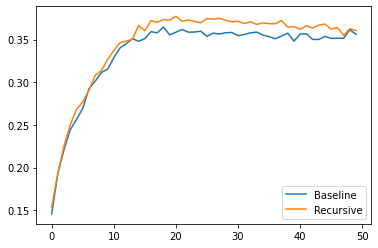

In [14]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losslist_n))), losslist_n, label="Baseline")
plt.plot(list(range(len(losslist_r))), losslist_r, label="Recursive")
plt.legend()
plt.show()